# A1 - Large IDF file with experimental and NDF fitted RBS-NRA-PIXE-SIMS data

## Introduction

Here we demonstrate three things:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. how an IDF file can contain a large amount of data, obtained from several IBA and SIMS techniques, in a self-  consistent and open-access friendly way;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. how an IDF can contain both experimental and theoretical data, including the circumstances in which both were  obtained;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. how to use the pyIBA library to easily create this IDF from scratch.   
  
The IDF outputted from the code below contains measurements from 4 different experimental techniques performed on a Be bulk sample. This sample was extracted from a fusion reactor wall, where it was implanted H, Mo, D, C, O, Cr, Fe, Cu, W, Ni. The measurements included are:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - a RBS measurement corresponding to 3 different reactions;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - a NRA measurement corresponding to 6 different reactions;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - a PIXE measurement;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - a SIMS measurement.  
    
The multi-technique analysis was made using the NDF code. The models (and their parameters) used are also saved in the IDF file, along with the obtained fits.  
  
Since we will be dealing with NDF, we will also introduce the methods to read the input parameters directly from the NDF input files. This will be done for two main reasons: 

1. convenience, since it is a complex experiment with a significant number of parameters;
2. to demonstrate how we can transform old analysis files into a single IDF file.

However, we recall that all the data imported from the NDF files can be introduced manually, as we did in the Basic Examples.

## Creating a IDF file with multiple spectra

As done in previous examples, we start by importing pyIBA, specificing the path to the input files and the name of the final IDF file:

In [72]:
# if pyIBA has been installed with pip3,
# the above 4 lines can be removed
import sys
from os.path import abspath
path_pyIBA = abspath('../../../../..')
sys.path.insert(0, path_pyIBA)

# import pyIBA, NDF and auxiliar metods
from pyIBA import IDF, auxiliar
from pyIBA.codes import NDF


In [73]:
folder_path = 'files_used_in_idf/' #'folder_to_NDF_files/'
file2save = 'IDF_multi_techinques.xml'

## Initialize a new (empty) IDF object

We are starting from scratch, so we create a blan IDF object (see [Example 1](../../Example1/blank_idf.ipynb)):

In [74]:
# this creates a new object IDF from pyIBA library
idf_file = IDF()

## Sample and overall description of the IDF file

Here we include the author of the IDF file, the description of the file and the sample details.

### General information

In [75]:
# set user name
idf_file.set_user('Miguel Sequeira')

# set description
description = ['File created to exemplify the IDF capabilities.',
               'The measurements are obtained from a Be sample with:',
               '1H ; Mo ; 2H ; 12C ; O ; Cr 1376 Fe 6136 Cu 2488 ; W ; Ni ; Be',
               'It contains: ',
               '- a RBS measurement corresponding to 3 different reactions;',
               '- a NRA measurement corresponding to 6 different reactions;',
               '- a PIXE measurement;',
               '- a SIMS measurement.',
               'The experimental parameters are included as well. For each measurement, the parameters used in NDF and corresponding fits are also saved.',  
              ]

# set the notes to the IDF file
for line in description:
    idf_file.set_note(line, append = True)    

### Load Elements from the str file of NDF

The str files are NDF input files where the sample details (e.g. elements, stoichiometry, etc...) are defined. Such details can also be inputed directly by defining the molecules dictionary by hand (see documentation for further details).

In [76]:
# point to the NDF str file
str_file = folder_path + 'Jari1.str'

idf_file.set_data_from_str_file(str_file, type = 'initial')

Alternatively, we could also load the elements from the str file using

    elements = pyIBA.codes.NDF.read_str_file(str_file)
   
edit them if needed and add them to the `idf_object`:

    idf_file.set_elements(elements)

## Experimental data

The geo files are NDF input files that contain all the information on the experiment geometry and reactions. We use the pyIBA to load this information directly from the geo files into the IDF file. If no geo files are presented, one can introduce the same information using the direct methods of **pyIBA** (e.g. see [Example 5](../../Example5/other_technques.ipynb#Introducing-basic-parameters) or [Example 1](../../Example1/blank_idf.ipynb#Adding-beam-parameters)).

> **Note**: geo files also contain information about the methods used to obtain the fits with the NDF (i.e. double scattering, pile-up and straggling, energy loss). By loading the geo file into the IDF, such details are also included in the final file.

### RBS data

The RBS experiment was made with 2300 keV protons and detects 3 reactions:
- the RBS one 1H -> 1H;
- and two 2 NRA:
    - Be(1H, 8Be)2H 0.56;
    - Be(1H, 6Li)4He 2.12.
        
We add this reactions to the same spectrum entry since they are detected simultanusely. This is done using the `set_reactions()` method, as we did for the case of NRA in [Example 5](../../Example5/other_technques.ipynb):


In [77]:
# point to the files concerning the RBS measurements and geometries containing the 3 different reactions measured
data_file_RBS = folder_path + 'RBS1_Jari_VTT_P_1.dat'
geo_files_RBS = [
    folder_path + 'G_RBS_2300_pp0.GEO',
    folder_path + 'G_RBS_2300_BeD.GEO',
    folder_path + 'G_RBS_2300_BeHe.GEO'
]

# # add 1 spectrum entry to the IDF file:
# idf_file.append_spectrum_entry(1)

# define the spectra_id of this RBS spectrum
spectra_id = 0

# add the geometry parameters from the NDF geo file corresponding to the RBS reaction;
# notice that we are not loading the analysis models when setting `add_models = False`
idf_file.set_data_from_geo_file(geo_files_RBS[0], add_models = False, spectra_id = spectra_id)

# set charge equal to 1
idf_file.set_charge(1, spectra_id = spectra_id)

#loop true the remaining geo files (note the [1:]) to add the NRA reactions
for geo in geo_files_RBS[1:]:
    # read the geometry parameters from the files
    geo_params = NDF.read_geo_file(geo)
    
    # set the reaction in this loop
    idf_file.set_reactions(geo_params['reactions'], spectra_id = spectra_id)
    
    
#     idf_file.set_energy_calibration(geo_params['calibration'][0], geo_params['calibration'][1], 
#                                     append = True, spectra_id = spectra_id)

# finally load spectra from the dat file
idf_file.set_spectrum_data_from_file(data_file_RBS, mode = '8 columns', spectra_id = spectra_id);


In [78]:
idf_file.get_reactions(spectra_id=0)

[{'initialtargetparticle': None,
  'incidentparticle': '1H',
  'exitparticle': '1H',
  'finaltargetparticle': None,
  'reactionQ': '',
  'code': '(1H, 1H)'},
 {'initialtargetparticle': 'Be',
  'incidentparticle': '1H',
  'exitparticle': '8Be',
  'finaltargetparticle': '2H',
  'reactionQ': '559.20',
  'code': 'Be(1H, 8Be)2H 559.20'},
 {'initialtargetparticle': 'Be',
  'incidentparticle': '1H',
  'exitparticle': '6Li',
  'finaltargetparticle': '4He',
  'reactionQ': '2125.00',
  'code': 'Be(1H, 6Li)4He 2125.00'}]

### NRA data

We now add the NRA data to the IDF object. To avoid overwriting the RBS data introduced above, we set

``` python
    spectra_id = 1
```

Similar to what we did above for the RBS data, we load the experimental details directly from the NDF's geo files.

Alike RBS, we have to add 6 reactions:

- D(3He, 1H)4He 18.35;
- Be(3He, 1H)11B 10.32;
- Be(3He, 1H)11B 8.19;
- Be(3He, 1H)11B 5.88;
- Be(3He, 1H)11B 5.30;
- 12C(3He, 1H)14N 4.78.
  
We add them to the IDF file in the same manner we did for the RBS.

In [79]:
# point to the files concerning the NRA measurements and geometries containing the 6 different reactions
data_file_NRA = folder_path + 'RBS2_Jari_VTT_He_1.dat'
geo_files_NRA = [
    folder_path + 'G_NRA_2300_Dp0.GEO',
    folder_path + 'G_NRA_2300_Bep0.GEO',
    folder_path + 'G_NRA_2300_Bep1.GEO',
    folder_path + 'G_NRA_2300_Bep2.GEO',
    folder_path + 'G_NRA_2300_Bep3.GEO',
    folder_path + 'G_NRA_2300_Cp0.GEO',    
]


# increate the number of spectra in the IDF to 2
idf_file.append_spectrum_entry(2)

# define the id of the NRA entry
spectra_id = 1

# add the geometry parameters from the geo file
idf_file.set_data_from_geo_file(geo_files_NRA[0], add_models=False, spectra_id = spectra_id)

# set charge equal to 1
idf_file.set_charge(1, spectra_id = spectra_id)

# add remaining reactions from the other geo files
for geo in geo_files_NRA[1:]:
    geo_params = NDF.read_geo_file(geo)
    idf_file.set_reactions(geo_params['reactions'], spectra_id = spectra_id)
    idf_file.set_energy_calibration(geo_params['calibration'][0], geo_params['calibration'][1], 
                                    append = True, spectra_id = spectra_id)

    
# load spectra from dat file
idf_file.set_spectrum_data_from_file(data_file_NRA, mode = '8 columns', spectra_id = spectra_id);

### PIXE data

Similar to what we did above for the RBS and NRA, we load the experimental details directly from the NDF's geo file. Here, we set:
``` python
    spectra_id = 2
```
    
  
>**Note**: The PIXE include here is in fact the output of the GUPIX since this is what is handled by  NDF.

In [80]:
# point to the file concerning the PIXE output from the cpixe code
data_file_PIXE = folder_path + 'CDTE_Jari_VTT_P_1.out'
geo_files_PIXE = folder_path + 'G_PIXE_2300.GEO'

# add the number of PIXE spectra entries to the IDF file:
idf_file.append_spectrum_entry(3)

# define the id of the PIXE entry
spectra_id = 2

# add the geometry parameters from the geo file
idf_file.set_data_from_geo_file(geo_files_PIXE, spectra_id = spectra_id)

# add the entire PIXE output to IDF file
idf_file.load_pixe_data_from_file(data_file_PIXE, spectra_id = spectra_id)

# set charge equal to 1
idf_file.set_charge(1, spectra_id = spectra_id)

### SIMS data

SIMS data can also be included in the IDF files, as we see next.
  
Since there is no NDF geometry file associated with SIMS, we input the experimental parameters using the **pyIBA** direct methods.
 
Note that the reaction dictionary used in `set_reaction(reaction_dic)` contains actually the particles detected in the SIMS measurement. Nontheless, note that most of the methods used to include the parameters are the same as the ones used for the IBA techniques.

In [81]:
# point to the file concerning the SIMS data
data_file_sims = folder_path + 'SIMS IDF.DAT'

# define the calibration parameters
sims_calibration_dic = {
    'particle': 'all',
    'mode': 'depth',
    'a': 1.0,
    'b': 0
}

# define the particles detected
reactions_dic = {
    'detectedparticles': '1H 2H Be 12C Ni Mo W',
}

# define the experimental parameters
params = {
    'incidentparticle': 'O2',
    'energy': 5,
    'window':[10,2500],
    'FWHM':500,
    'solid_angle':1,    
}


# set the number of spectra entries in the IDF file to 4:
idf_file.append_spectrum_entry(4)

# define the id of the SIMS entry
spectra_id = 3

# since there is no geo file for this SIMS, we define the geometry parameters manually
idf_file.set_beam_particles(params['incidentparticle'], spectra_id=spectra_id)
idf_file.set_beam_energy(params['energy'], spectra_id=spectra_id)
idf_file.set_beam_energy_spread(params['FWHM'], spectra_id=spectra_id)
idf_file.set_SIMS_calibration(sims_calibration_dic, spectra_id = spectra_id)
idf_file.set_technique('SIMS', spectra_id = spectra_id)
idf_file.set_reactions(reactions_dic, mode = 'masslist', spectra_id = spectra_id)
idf_file.set_window_min(params['window'][0], spectra_id=spectra_id)
idf_file.set_window_max(params['window'][1], spectra_id=spectra_id)
idf_file.set_detector_solid_angle(params['solid_angle'], spectra_id=spectra_id)

# add the SIMS measured data
idf_file.set_SIMS_from_file(data_file_sims, spectra_id = spectra_id)
idf_file.set_spectrum_file_name(data_file_sims.split('/')[-1], spectra_id= spectra_id)

## Analysis data

We now add the fits and related results obtained with NDF. The results below have been obtained from fitting the entire set of experimental data. Thus, we have to include:

- 3 fits for the RBS;
- 6 fits for the NRA;
- 1 fit for PIXE;
- 1 fit for SIMS;
- the resultant stoichiometry (the str file);
- the resultant depth profile (the prf file).

Each technique and reaction will also use different analysis models (e.g. Double Scattering, Pile-up) and thus the reason for a geo file for each simulation. So, we first set the number of simulations in each spectra entry using `append_simulation_entry()`, a similar method to `append_spectrum_entry`. Afterwards we add the parameters from the geo files for each technique/reaction. Finally we add the corresponding fits.

### RBS data

To load the models for the 3 reactions by running:

In [82]:
# set the spectra_id of the RBS entry
spectra_id = 0

# change the total number of simulations on this entry to 3
idf_file.append_simulation_entry(len(geo_files_RBS), spectra_id = spectra_id)

# loop through each geo file while and reaction
for sim_id, geo in enumerate(geo_files_RBS):
    # add analysis models from geo file
    idf_file.set_models_from_geo_file(geo, spectra_id=spectra_id, simulation_id=sim_id)

Now add the fits:

In [83]:
# point to the fit dat file
data_file_RBS_fit = [
    folder_path + 'Jarf0101.dat',
    folder_path + 'Jarf0102.dat',
    folder_path + 'Jarf0103.dat',
]

for sim_id, fit in enumerate(data_file_RBS_fit):
    # load the experimental and fit data from the file
    channels, yields, fit = auxiliar.load_spectrum_from_file(fit, mode = 'NDF simulation')

    # add the channels and fits to the RBS sections of the IDF file 
    idf_file.set_spectrum_data_fit_result(channels, fit, spectra_id=spectra_id, simulation_id=sim_id)

### NRA data

In [84]:
spectra_id = 1

idf_file.append_simulation_entry(len(geo_files_NRA), spectra_id=spectra_id)
for sim_id, geo in enumerate(geo_files_NRA):
    idf_file.set_models_from_geo_file(geo, spectra_id=spectra_id, simulation_id=sim_id)


In [85]:
data_file_NRA_fit = [
    folder_path + 'Jarf0104.dat',
    folder_path + 'Jarf0105.dat',
    folder_path + 'Jarf0106.dat',
    folder_path + 'Jarf0107.dat',
    folder_path + 'Jarf0108.dat',
    folder_path + 'Jarf0109.dat'    
]


for sim_id, fit in enumerate(data_file_NRA_fit):
    # load the data from the file
    channels, yields, fit = auxiliar.load_spectrum_from_file(fit, mode = 'NDF simulation')

    # add the channels and fits to the RBS sections of the IDF file 
    idf_file.set_spectrum_data_fit_result(channels, fit, spectra_id=spectra_id, simulation_id=sim_id)

### PIXE data

In [86]:
data_file_PIXE_fit = folder_path + 'Jarf0117.dat'

spectra_id = 2
lines, area = auxiliar.read_pixe_file(data_file_PIXE_fit, mode = 'NDF simulation')

idf_file.set_PIXE_data_fit_result(lines, area, spectra_id = spectra_id)

### SIMS data

In [87]:
data_file_sims = folder_path + 'SIMS IDF - fits.DAT'

spectra_id = 3
sims_data = auxiliar.load_SIMS_file(data_file_sims)

idf_file.set_SIMS_data_fit(sims_data, spectra_id=spectra_id)

### Set elements results from str file

Each technique can have its own set of results. However, since the analysis was done simultaneously, all the techniques share the same elements results.

In [88]:
# point to the output file with the fit results for the elements 
str_file = folder_path + 'Jars01.str'

# get the number of spectra in the file
nspectra = idf_file.get_number_of_spectra()

# loop through every technique
for i in range(nspectra):
    nsims = idf_file.get_number_of_simulations(spectra_id = i)
    for j in range(nsims):
        idf_file.set_data_from_str_file(str_file, spectra_id = i, simulation_id = j)

### Set profile results from prf file

In [89]:
prf_file = folder_path + 'Jar01.prf'

nspectra = idf_file.get_number_of_spectra()

for i in range(nspectra):
    nsims = idf_file.get_number_of_simulations(spectra_id = i)
    for j in range(nsims):
        idf_file.set_data_from_prf_file(prf_file, spectra_id = i, simulation_id = j)

## Set NDF run options

We also add the NDF run options used to obtain the above fits. Since all of the fits were obtained simultaneously, the same options are shared between the different techniques.

In [90]:
for id in range(idf_file.get_number_of_spectra()):
    for sim_id in range(idf_file.get_number_of_simulations(spectra_id = id)):
        idf_file.set_NDF_run_option('fitmethod', '6 - Custom (TCN)', spectra_id=id, simulation_id = sim_id)
        idf_file.set_NDF_run_option('channelcompreesion', '0 - No compression', spectra_id=id, simulation_id = sim_id)
        idf_file.set_NDF_run_option('convolute', '1 - Convolute FWHM', spectra_id=id, simulation_id = sim_id)
        idf_file.set_NDF_run_option('distribution', '1 - Use isotropic distribution', spectra_id=id, simulation_id = sim_id)
        idf_file.set_NDF_run_option('smooth', '0 - Don\'t smooth data', spectra_id=id, simulation_id = sim_id)
        idf_file.set_NDF_run_option('normalisation', '1 - Normalise profile', spectra_id=id, simulation_id = sim_id)

## Save IDF file

Finally we save the IDF file:

In [91]:
idf_file.save_idf(file2save);

## Retrive data and plot everything

In [92]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

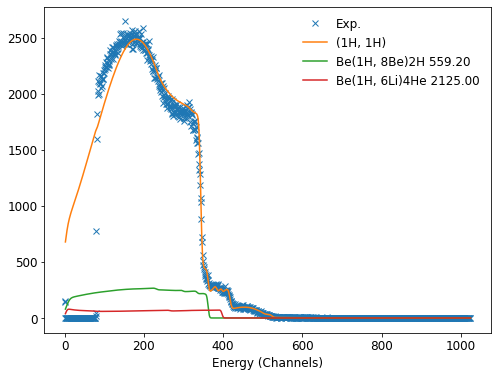

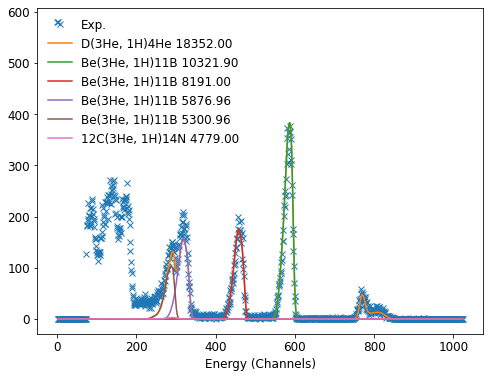

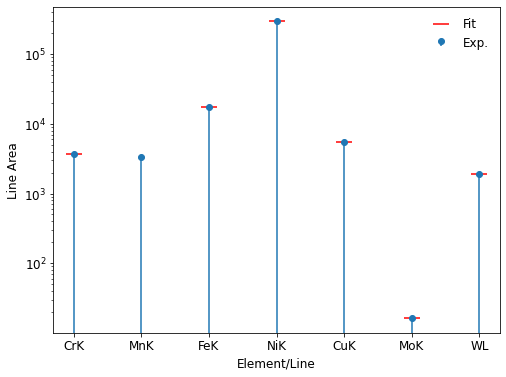

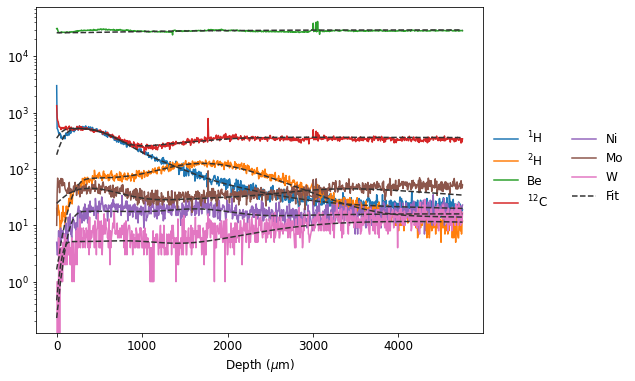

In [93]:

for id in range(0,4):
    nsim = idf_file.get_number_of_simulations(spectra_id = id)
    technique = idf_file.get_technique(spectra_id = id)
    
    
    plt.figure(figsize = (8,6))
    
    xx_exp, yy_exp = idf_file.get_dataxy(spectra_id=id)
    
    if technique in ['RBS', 'NRA']:
        plt.plot(xx_exp, yy_exp, 'x', label = 'Exp.')
    
        for sim_id in range(0, nsim):
            xx, yy = idf_file.get_dataxy_fit(spectra_id=id, simulation_id=sim_id)
            name = idf_file.get_reactions(spectra_id=id)[sim_id]['code']
            plt.plot(xx, yy, label = name)
            
        plt.xlabel('Energy (Channels)')
        plt.legend(frameon=False)
        
    elif 'PIXE' == technique:
        plt.stem(xx_exp, yy_exp, basefmt = ' ', label = 'Exp.')
        
        xx, yy = idf_file.get_dataxy_fit(spectra_id=id)
        plt.scatter(xx, yy, marker = '_', s = 250, color = 'r', label = 'Fit')
        
        plt.xlabel('Element/Line')
        plt.ylabel('Line Area')
        plt.legend(frameon=False)
        plt.yscale('log')
        
    elif 'SIMS' == technique:
        for particle, profile in yy_exp.items():
            plt.plot(xx_exp, profile, label = r'%s'%auxiliar.latex_atom(particle))
        
        xx, yy = idf_file.get_dataxy_fit(spectra_id=id)
        
        for particle, profile in yy.items():
            plt.plot(xx, profile, '--', color = (0.2,0.2,0.2))

        plt.plot([],[], '--', color = (0.2,0.2,0.2), label = 'Fit')

        plt.yscale('log')
        plt.xlabel(r'Depth ($\mu$m)')
        plt.legend(frameon = False, ncol= 2, loc='center left', bbox_to_anchor=(1, 0.5))

## Checking the file

As done in previous examples, the contents of the IDF file can be checked using:

=============== IDF_multi_techinques ===============
IDF_multi_techinques.xml
Miguel Sequeira 

------------------  Notes  ------------------

File created to exemplify the IDF capabilities.
The measurements are obtained from a Be sample with:
1H ; Mo ; 2H ; 12C ; O ; Cr 1376 Fe 6136 Cu 2488 ; W ; Ni ; Be
It contains: 
- a RBS measurement corresponding to 3 different reactions;
- a NRA measurement corresponding to 6 different reactions;
- a PIXE measurement;
- a SIMS measurement.
The experimental parameters are included as well. For each measurement, the parameters used in NDF and corresponding fits are also saved.

------------------ Elements -----------------
nelements 	 9

 - - - Element 0 - - -
name 		 1 H
density  	 
concentration  	 ['0', '0.02']
depth 		 ['0', '200000']

 - - - Element 1 - - -
name 		 Mo
density  	 
concentration  	 ['0', '0.1']
depth 		 ['0', '200000']

 - - - Element 2 - - -
name 		 2 H
density  	 
concentration  	 ['0', '0.1']
depth 		 ['0', '180000']

 - - -

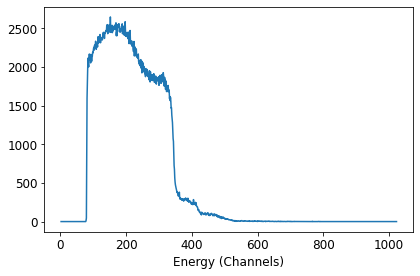

-------- Spectrum 1 (RBS2_Jari_VTT_He_1.dat) --------
Technique 	NRA
		 D(3He, 1H)4He 18352.00
		 Be(3He, 1H)11B 10321.90
		 Be(3He, 1H)11B 8191.00
		 Be(3He, 1H)11B 5876.96
		 Be(3He, 1H)11B 5300.96
		 12C(3He, 1H)14N 4779.00


Projectile  	 3He
Beam energy  	 2300.0
Beam fwhm  	 20.0
Geometry  	 cornell
Angles  	 ['0', '135']
Dect solid  	 34.00
Energy calib  	 [15.4, 280.78]
Charge  	 1


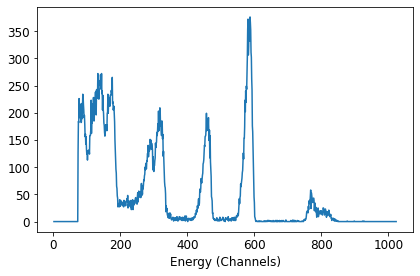

-------- Spectrum 2 (CDTE_Jari_VTT_P_1.out) --------
Technique 	PIXE
		 (1H, X)


Projectile  	 1H
Beam energy  	 2300.0
Beam fwhm  	 15.0
Geometry  	 cornell
Angles  	 ['0', '150']
Dect solid  	 10.00
Energy calib  	 ['Mar2016.eff', 'Calibra��o do detector Gresham em Dezembro de 2005 � energia de 1220 keV CGrDez05\n 1220.000\n EkeV       Eff. Teo.\n :::::::::::::::::::::::::::::::\n EFFIFILEVERSION 3\n \n DETECTORCURVE\n 1.000\t9.479E-05\n 1.011\t1.171E-04\n 1.012\t1.063E-04\n 1.041\t1.795E-04\n 1.100\t4.481E-04\n 1.142\t7.755E-04\n 1.143\t7.850E-04\n 1.200\t1.478E-03\n 1.250\t2.366E-03\n 1.253\t2.428E-03\n 1.300\t3.548E-03\n 1.379\t6.055E-03\n 1.400\t6.853E-03\n 1.487\t1.071E-02\n 1.500\t1.136E-02\n 1.600\t1.711E-02\n 1.700\t2.363E-02\n 1.740\t2.638E-02\n 1.750\t2.707E-02\n 1.806\t3.100E-02\n 1.838\t3.327E-02\n 1.839\t3.334E-02\n 1.900\t3.767E-02\n 2.000\t4.468E-02\n 2.014\t4.568E-02\n 2.042\t4.766E-02\n 2.100\t5.168E-02\n 2.166\t5.612E-02\n 2.200\t5.833E-02\n 2.205\t5.865E-02\n 2.20

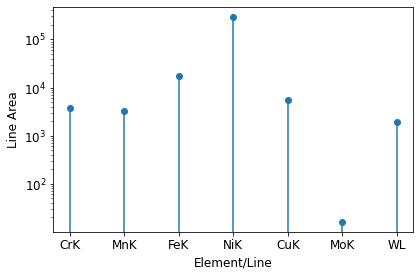

-------- Spectrum 3 (SIMS IDF.DAT) --------
Technique 	SIMS


Projectile  	 O2
Beam energy  	 5.0
Beam fwhm  	 500.0
Geometry  	 
Angles  	 ['', '']
Dect solid  	 1
Energy calib  	 ['1.0', '0']
Plotting not supported for SIMS


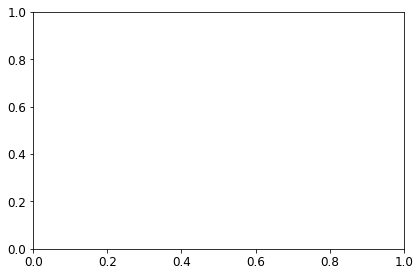

In [94]:
idf_file.print_idf_file()